# Energy imbalance in the ocean
Andrew Delman. Updated 2025-05-04.

This tutorial covers the ocean's role in the Earth's energy imbalance, as depicted in the ECCO state estimate. The two ECCO releases v4r4 and v4r5 are analyzed and compared.

```{note}
This tutorial should be run on a server/instance with a minimum of 32 GB RAM for good performance.
```

## Objectives

- Quantify the ocean heat content (OHC) change
- Quantify heat fluxes entering the ocean through the surface, as well as the geothermal flux
- Compute time mean and trends in OHC change and heat fluxes, and consider implications for the ocean's energy imbalance

## Introduction

The [Earth's energy imbalance (EEI)](https://wmo.int/media/news/new-study-shows-earth-energy-imbalance) is a key indicator of changes in Earth's air temperature and climate. The atmospheric temperature change is the net flux of radiative energy through the top of the atmosphere, minus the heat fluxes to the oceans, land, and cryosphere (ice). Of the heat stored as a result of EEI, one recent study [(von Schuckmann et al. 2023)](https://essd.copernicus.org/articles/15/1675/2023/) estimated that ~89% has accumulated in the oceans. Therefore closing the Earth's energy budget requires an accurate estimate heat storage in the ocean, and how much of that storage is the result of fluxes atmosphere->ocean vs. from other sources.

There are two ways to estimate the ocean's energy imbalance from observations: (1) by observing the temperature change in the ocean directly, and (2) by observing the fluxes of heat into the ocean. Since the uncertainties of the data products are significant relative to the signal of the energy imbalance itself, being able to use both methods is important for constraining estimates of energy imbalance and lowering uncertainties.

## Ocean heat content change

First, let's quantify the OHC change using ECCO. Note that these computations are an abbreviated version of this ECCO [heat budget tutorial](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Heat_budget_closure.html). In this case we do not quantify heat advection and diffusion within the ocean, since we are only concerned with the global OHC change, rather than heat redistribution within the ocean.

The code below computes the total temperature tendency in the ocean (vertical mean), as well as the contribution of "forcing" to the tendency. In this case "forcing" is the heat flux through the ocean surface from the atmosphere and sea-ice, as well as the geothermal flux through the ocean floor.

In [1]:
%pdb on

# import needed packages
import numpy as np
import xarray as xr
import dask.array
import glob
import matplotlib.pyplot as plt
import requests

from os.path import expanduser,join,exists
import sys
user_home_dir = expanduser('~')
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import ecco_v4_py.ecco_access as ea



def geoflx_retrieve(ecco_grid,geoflx_dir=join(user_home_dir,'Downloads')):
    """Retrieve geothermal flux data and load into workspace"""
    
    # Make copy of hFacC
    mskC = ecco_grid.hFacC.copy(deep=True).compute()
    
    # Change all fractions (ocean) to 1. land = 0
    mskC.values[mskC.values>0] = 1

    geoflx_filename = join(geoflx_dir,'geothermalFlux.bin')
    if ~exists(geoflx_filename):
        # Load the geothermal heat flux using the routine 'read_llc_to_tiles'.
        r = requests.get(\
                'https://github.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/raw/refs/heads/master/misc/geothermalFlux.bin')
    
        # save geothermal flux to file in local directory geoflx_dir
        geoflx_filename = join(geoflx_dir,'geothermalFlux.bin')
        with open(geoflx_filename,'wb') as f:
            for chunk in r.iter_content(chunk_size=1024):
                f.write(chunk)
    
    
    geoflx = ecco.read_llc_to_tiles(geoflx_dir, 'geothermalFlux.bin')
    # Convert numpy array to an xarray DataArray with matching dimensions as the monthly mean fields
    geoflx_llc = xr.DataArray(geoflx,coords={'tile': ecco_grid.tile.values,
                                             'j': ecco_grid.j.values,
                                             'i': ecco_grid.i.values})
    # Create 3d bathymetry mask
    mskC_shifted = mskC.shift(k=-1)
    
    mskC_shifted.values[-1,:,:,:] = 0
    mskb = mskC - mskC_shifted
    
    # Create 3d field of geothermal heat flux
    geoflx3d = geoflx_llc * mskb.transpose('k','tile','j','i')
    GEOFLX = geoflx3d.transpose('k','tile','j','i')
    GEOFLX.attrs = {'standard_name': 'GEOFLX','long_name': 'Geothermal heat flux','units': 'W/m^2'}

    return GEOFLX
    

def temp_tend_forcing_vertmean_compute(version='v4r4',StartDate='1992-01',EndDate='2017-12'):
    """Compute vertical mean of total temperature tendency
       and forcing (surface flux & geothermal) contribution.
       Computation can be done with v4r4 or v4r5 output;
       v4r4 temperature tendency is computed using snapshots at month boundaries, 
       while v4r5 temperature tendency is computed using interpolation
       from monthly mean data."""

    # Seawater density (kg/m^3)
    rhoconst = 1029
    ## needed to convert surface mass fluxes to volume fluxes
    
    # Heat capacity (J/kg/K)
    c_p = 3994
    
    # Constants for surface heat penetration (from Table 2 of Paulson and Simpson, 1977)
    R = 0.62
    zeta1 = 0.6
    zeta2 = 20.0
    
    
    # ShortNames
    if version == 'v4r4':
        
        ## access datasets needed for this tutorial
        
        ShortNames_list = ["ECCO_L4_HEAT_FLUX_LLC0090GRID_MONTHLY_V4R4",\
                           "ECCO_L4_FRESH_FLUX_LLC0090GRID_MONTHLY_V4R4",\
                           "ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4",\
                           "ECCO_L4_SSH_LLC0090GRID_SNAPSHOT_V4R4",\
                           "ECCO_L4_TEMP_SALINITY_LLC0090GRID_SNAPSHOT_V4R4"]
        
        access_mode = 's3_open_fsspec'
        # for access_mode = 's3_open_fsspec', need to specify the root directory 
        # containing the jsons
        jsons_root_dir = join('/efs_ecco','mzz-jsons')
        
    elif version == 'v4r5':
        ShortNames_list = ["ECCO_L4_OCEAN_AND_ICE_SURFACE_HEAT_FLUX_LLC0090GRID_MONTHLY_V4R5",\
                           "ECCO_L4_OCEAN_AND_ICE_SURFACE_FW_FLUX_LLC0090GRID_MONTHLY_V4R5",\
                           "ECCO_L4_OCEAN_TEMPERATURE_SALINITY_LLC0090GRID_MONTHLY_V4R5",\
                           "ECCO_L4_SEA_SURFACE_HEIGHT_LLC0090GRID_MONTHLY_V4R5"]
    
        access_mode = 's3_open'
        jsons_root_dir = None
        
    
    # load grid parameters
    if version == 'v4r4':
        ecco_grid = ea.ecco_podaac_to_xrdataset("ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                                                  version='v4r4',\
                                                  mode=access_mode,\
                                                  jsons_root_dir=jsons_root_dir)
    elif version == 'v4r5':
        ecco_grid = xr.open_dataset('/efs_ecco/ECCO/V4/r5/grid/nctiles_grid/ECCO-GRID.nc')
    ecco_grid = ecco_grid.compute()
    
    
    ds_dict = ea.ecco_podaac_to_xrdataset(ShortNames_list,\
                                                StartDate=StartDate,EndDate=EndDate,\
                                                version=version,\
                                                snapshot_interval='monthly',\
                                                mode=access_mode,\
                                                jsons_root_dir=jsons_root_dir,\
                                                show_noredownload_msg=False,\
                                                prompt_request_payer=False)
    
    
    # Volume (m^3)
    vol = (ecco_grid.rA*ecco_grid.drF*ecco_grid.hFacC).transpose('tile','k','j','i').compute()
    
    year_start = np.int64(StartDate[:4])
    year_end = np.int64(EndDate[:4])

    if version == 'v4r4':
        # open ETAN and THETA snapshots (beginning of each month)
        ecco_monthly_SSH = ds_dict[ShortNames_list[-2]]
        ecco_monthly_TS = ds_dict[ShortNames_list[-1]]
        ecco_monthly_snaps = xr.merge((ecco_monthly_SSH['ETAN'],ecco_monthly_TS['THETA']))
    elif version == 'v4r5':
        # we don't have SSH and temp snapshots, so estimate based on interpolation
        ecco_monthly_ETAN = ds_dict[ShortNames_list[3]]['ETAN'].transpose('time','tile','j','i').data
        ecco_monthly_THETA = ds_dict[ShortNames_list[2]]['THETA'].transpose('time','k','tile','j','i').data
        time_bnds = ds_dict[ShortNames_list[3]].time_bnds.isel(time=slice(0,-1),nv=1).data
        ETAN_interp = ecco_monthly_ETAN[:-1,:,:,:] + (np.diff(ecco_monthly_ETAN,axis=0)/2)
        THETA_interp = ecco_monthly_THETA[:-1,:,:,:,:] + (np.diff(ecco_monthly_THETA,axis=0)/2)
        
        ecco_monthly_snaps = xr.Dataset(coords={**{'time':time_bnds},**ecco_grid[['Z','XC','YC']]},\
                                        data_vars={'ETAN':(['time','tile','j','i'],ETAN_interp),\
                                                   'THETA':(['time','k','tile','j','i'],THETA_interp)}\
                                       )
        
    # time mask for snapshots
    time_snap_mask = np.logical_and(ecco_monthly_snaps.time.values >= np.datetime64(str(year_start)+'-01-01','ns'),\
                                    ecco_monthly_snaps.time.values < np.datetime64(str(year_end+1)+'-01-02','ns'))
    
    ecco_monthly_snaps = ecco_monthly_snaps.isel(time=time_snap_mask)
    
    ## Consolidate ECCO monthly mean variables needed into one dataset
    
    ecco_vars_sfc = ds_dict[ShortNames_list[0]]
    ecco_vars_sfcFW = ds_dict[ShortNames_list[1]]
    ecco_vars_TS = ds_dict[ShortNames_list[2]]
    
    ecco_monthly_mean = xr.merge((ecco_vars_sfc[['TFLUX','oceQsw','oceQnet']],\
                                  ecco_vars_sfcFW['oceFWflx'],\
                                  ecco_vars_TS['THETA']))
    
    # time mask for monthly means
    time_mean_mask = np.logical_and(ecco_monthly_mean.time.values >= np.datetime64(str(year_start)+'-01-01','ns'),\
                                    ecco_monthly_mean.time.values < np.datetime64(str(year_end+1)+'-01-01','ns'))
    
    ecco_monthly_mean = ecco_monthly_mean.isel(time=time_mean_mask)
    
    
    # Drop superfluous coordinates (We already have them in ecco_grid)
    ecco_monthly_mean = ecco_monthly_mean.reset_coords(drop=True)

    # pad time axis of snapshot dataset as needed
    if ecco_monthly_snaps.sizes['time'] <= ecco_monthly_mean.sizes['time']:
        n_pad_end = ecco_monthly_mean.sizes['time'] - ecco_monthly_snaps.sizes['time']
        ecco_monthly_snaps = ecco_monthly_snaps.pad(pad_width={'time':(1,n_pad_end)},mode='constant',\
                                                    constant_values=np.nan)

    # merge all datasets into one
    ds = xr.merge([ecco_monthly_mean,\
                   ecco_monthly_snaps.rename({'time':'time_snp','ETAN':'ETAN_snp', 'THETA':'THETA_snp'}),\
                   ecco_grid[['hFacC','drF','rA']]])
    
    # Change time axis of the snapshot variables
    ds.time_snp.attrs['c_grid_axis_shift'] = 0.5
    
    # get LLC grid object
    grid = ecco.get_llc_grid(ds)
    
    
    
    ## compute vertical mean temperature tendency
    
    delta_t = xr.DataArray(np.diff(ds.time_snp.data),coords={'time':ds.time})
    
    # Convert to seconds
    delta_t = delta_t.astype('f4') / 1e9
    
    
    # Calculate the s*theta term
    sTHETA = ds.THETA_snp*(1+ds.ETAN_snp/ecco_grid.Depth)
    
    
    # Total tendency (psu/s)
    G_total = sTHETA.diff(dim='time_snp')/np.expand_dims(delta_t.values,axis=(1,2,3,4))
    
    # re-assign and rename time coordinate
    G_total = G_total.rename({'time_snp':'time'})
    G_total = G_total.assign_coords({'time':delta_t.time.values})

    # vertical mean of G_total
    depth_int_masked = (ds.hFacC*ds.drF).compute()
    
    G_total_vertmean = (((depth_int_masked*G_total).sum('k'))/\
                          (depth_int_masked.sum('k')))\
                            .transpose('time','tile','j','i').compute()
    G_total_vertmean = G_total_vertmean.where(np.abs(G_total_vertmean) > 1.e-16,np.nan)
    
    
    # The weights are just the number of seconds per month divided by total seconds
    month_length_weights = delta_t / delta_t.sum()    

    print('Total temp tend computed,',version)

    
    ## compute forcing flux
    def forcH_compute(ds,ecco_grid):
        
        Z = ecco_grid.Z.compute()
        RF = np.concatenate([ecco_grid.Zp1.values[:-1],[np.nan]])
        
        q1 = R*np.exp(1.0/zeta1*RF[:-1]) + (1.0-R)*np.exp(1.0/zeta2*RF[:-1])
        q2 = R*np.exp(1.0/zeta1*RF[1:]) + (1.0-R)*np.exp(1.0/zeta2*RF[1:])
        
        # Correction for the 200m cutoff
        zCut = np.where(Z < -200)[0][0]
        q1[zCut:] = 0
        q2[zCut-1:] = 0
        
        # Create xarray data arrays
        q1 = xr.DataArray(q1,coords=[Z.k],dims=['k'])
        q2 = xr.DataArray(q2,coords=[Z.k],dims=['k'])
        
        ## Land masks
        # Make copy of hFacC
        mskC = ecco_grid.hFacC.copy(deep=True).compute()
        
        # Change all fractions (ocean) to 1. land = 0
        mskC.values[mskC.values>0] = 1
        
        # Shortwave flux below the surface (W/m^2)
        oceQsw = ds.oceQsw.compute()
        forcH_subsurf = ((q1*(mskC==1)-q2*(mskC.shift(k=-1)==1))*oceQsw).transpose('time','k','tile','j','i')
        
        # Surface heat flux (W/m^2)
        forcH_surf = ((ds.TFLUX.compute() - (1-(q1[0]-q2[0]))*oceQsw)\
                      *mskC[0]).transpose('time','tile','j','i').assign_coords(k=0).expand_dims('k')
        
        # Full-depth sea surface forcing (W/m^2)
        forcH = xr.concat([forcH_surf,forcH_subsurf.isel(k=slice(1,None))],dim='k').transpose('time','k','tile','j','i')
                
        return forcH
    
    
    ## vertical mean of forcing tendency    
    
    # Load the geothermal heat flux
    GEOFLX = geoflx_retrieve(ecco_grid)

    
    # compute in chunks in order to limit memory usage

    depth_int_masked = (ds.hFacC*ds.drF).compute()
    
    G_forcing_vertmean_array = np.empty(G_total_vertmean.shape)
    G_forcing_vertmean_array.fill(np.nan)
    t_chunksize = 24
    for chunk in range(0,int(np.ceil(ds.sizes['time']/t_chunksize))):
        curr_t = slice(chunk*t_chunksize,np.fmin((chunk+1)*t_chunksize,ds.sizes['time']))
        # compute surface (and subsurface shortwave) forcing flux
        curr_forcH = forcH_compute(ds.isel(time=curr_t),ecco_grid)
        
        # Add geothermal heat flux to forcing field and convert from W/m^2 to degC/s
        curr_G_forcing = ((curr_forcH + GEOFLX)/(rhoconst*c_p))/(ecco_grid.hFacC*ecco_grid.drF)

        # depth average
        G_forcing_vertmean_array[curr_t,:,:,:] = (((depth_int_masked*curr_G_forcing).sum('k'))/\
                                                      (depth_int_masked.sum('k')))\
                                                        .transpose('time','tile','j','i').values
    G_forcing_vertmean = xr.DataArray(G_forcing_vertmean_array,dims=['time','tile','j','i'])   

    print('Forcing temp tend computed,',version)

    
    return G_total_vertmean,G_forcing_vertmean,ds


G_total_vertmean_v4r4,G_forcing_vertmean_v4r4,ds_v4r4 = \
                        temp_tend_forcing_vertmean_compute(version='v4r4',\
                                                  StartDate='1992-01',EndDate='2017-12')

G_total_vertmean_v4r5,G_forcing_vertmean_v4r5,ds_v4r5 = \
                        temp_tend_forcing_vertmean_compute(version='v4r5',\
                                                  StartDate='1992-01',EndDate='2019-12')

Automatic pdb calling has been turned ON


/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Total temp tend computed, v4r4
load_binary_array: loading file /home/jovyan/Downloads/geothermalFlux.bin
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
Forcing temp tend computed, v4r4

Total number of matching granules: 336

Total number of matching granules: 336

Total number of matching granules: 336

Total number of matching granules: 336


/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Total temp tend computed, v4r5
load_binary_array: loading file /home/jovyan/Downloads/geothermalFlux.bin
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
Forcing temp tend computed, v4r5


/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Having computed the vertical mean, we then compute the global volumetric mean of the total tendency and the forcing contribution. The global mean is obtained from the vertical means by horizontally averaging, with the area*depth of the water column as weights.

In [2]:
access_mode = 's3_open_fsspec'
jsons_root_dir = join('/efs_ecco','mzz-jsons')
ecco_grid_v4r4 = ea.ecco_podaac_to_xrdataset("ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                                                  version='v4r4',\
                                                  mode=access_mode,\
                                                  jsons_root_dir=jsons_root_dir)
ocean_vol_weights_v4r4 = (ecco_grid_v4r4.hFacC*ecco_grid_v4r4.rA*ecco_grid_v4r4.drF).sum('k').compute()
ocean_vol_v4r4 = ocean_vol_weights_v4r4.sum(['tile','j','i'])

ecco_grid_v4r5 = xr.open_mfdataset('/efs_ecco/ECCO/V4/r5/grid/nctiles_grid/ECCO-GRID.nc')
ocean_vol_weights_v4r5 = (ecco_grid_v4r5.hFacC*ecco_grid_v4r5.rA*ecco_grid_v4r5.drF).sum('k').compute()
ocean_vol_v4r5 = ocean_vol_weights_v4r5.sum(['tile','j','i'])


def tend_terms_globmean_compute(G_forcing_vertmean,G_total_vertmean,\
                                ocean_vol_weights,ocean_vol):

    G_forcing_globmean = ((ocean_vol_weights*G_forcing_vertmean).sum(['tile','j','i'])\
                                /ocean_vol).compute()
    G_total_globmean = ((ocean_vol_weights*G_total_vertmean).sum(['tile','j','i'])\
                                /ocean_vol).compute()

    return G_forcing_globmean,G_total_globmean

G_forcing_globmean_v4r4,G_total_globmean_v4r4 = \
                                        tend_terms_globmean_compute(G_forcing_vertmean_v4r4,\
                                                                    G_total_vertmean_v4r4,\
                                                                    ocean_vol_weights_v4r4,ocean_vol_v4r4)

G_forcing_globmean_v4r5,G_total_globmean_v4r5 = \
                                        tend_terms_globmean_compute(G_forcing_vertmean_v4r5,\
                                                                    G_total_vertmean_v4r5,\
                                                                    ocean_vol_weights_v4r5,ocean_vol_v4r5)

Now let's check that the "forcing" (surface flux + geothermal) contribution explains the global mean heating of the ocean. For these plots, let's convert the units from temperature tendency (useful in budget calculations) to rate of ocean heat content change. To do this we multiply the temperature tendency by the volume of the ocean, density (rhoConst), and heat capacity (c_p) to obtain rate of global ocean heat change. You can track how these multiplications change the units from $^{\circ}$C s$^{-1}$ to J $s^{-1}$, also known as Watts or W:

- (C s$^{-1}$) * (m$^3$)(kg m$^{-3}$)(J kg$^{-1}$ C$^{-1}$) = J s$^{-1}$ = W

In [3]:
rhoConst = 1029
c_p = 3994


OHC_change_forcing_globmean_v4r4 = (ocean_vol_v4r4*rhoConst*c_p*G_forcing_globmean_v4r4)
OHC_change_total_globmean_v4r4 = (ocean_vol_v4r4*rhoConst*c_p*G_total_globmean_v4r4)
# mask out zero values
OHC_change_total_globmean_v4r4 = OHC_change_total_globmean_v4r4\
                                    .where(np.abs(OHC_change_total_globmean_v4r4) > 1.e-3,np.nan)

OHC_change_forcing_globmean_v4r5 = (ocean_vol_v4r5*rhoConst*c_p*G_forcing_globmean_v4r5)
OHC_change_total_globmean_v4r5 = (ocean_vol_v4r5*rhoConst*c_p*G_total_globmean_v4r5)
# mask out zero values
OHC_change_total_globmean_v4r5 = OHC_change_total_globmean_v4r5\
                                    .where(np.abs(OHC_change_total_globmean_v4r5) > 1.e-10,np.nan)

In [4]:
# compute time means, given time weights
def tmean_compute(field,time_weights):
    field_tmean = (time_weights*field).sum('time')/(time_weights.sum('time'))

    return field_tmean

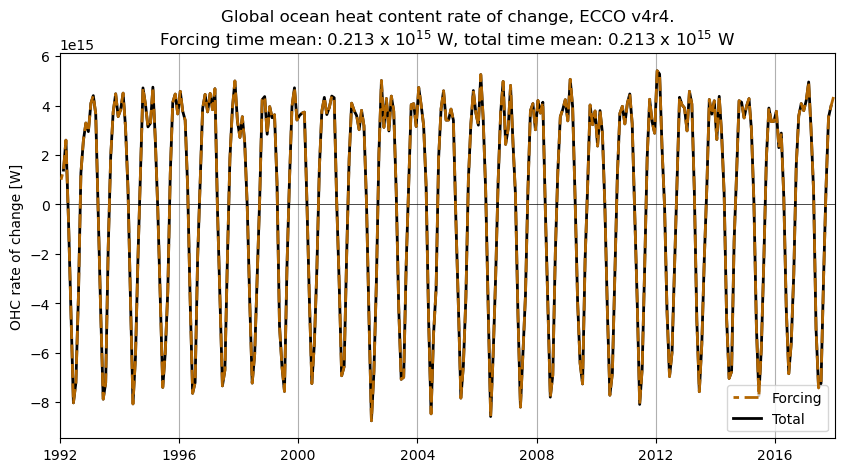

In [5]:
# time means, excluding first and last months when total tendencies are not available
delta_t_v4r4 = xr.DataArray(np.diff(ds_v4r4.time_snp.values).astype('float64')/(1.e9),dims=['time'])
OHC_change_forcing_globmean_tmean_v4r4 = tmean_compute(OHC_change_forcing_globmean_v4r4[1:-1],\
                                                       delta_t_v4r4[1:-1])
OHC_change_total_globmean_tmean_v4r4 = tmean_compute(OHC_change_total_globmean_v4r4[1:-1],\
                                                     delta_t_v4r4[1:-1])

# plot OHC rate of change, v4r4
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(ds_v4r4.time.values,OHC_change_forcing_globmean_v4r4.values,\
        color=(.7,.4,0),linewidth=2,linestyle=(3,(5,2)),zorder=10,label='Forcing')
ax.plot(ds_v4r4.time.values,OHC_change_total_globmean_v4r4.values,\
        color=(0,0,0),linewidth=2,label='Total')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.grid(axis='x')
ax.set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2018-01-01','ns')])
ax.set_ylabel('OHC rate of change [W]')
ax.set_title('Global ocean heat content rate of change, ECCO v4r4.\n'\
             +'Forcing time mean: '+("%.3f" % ((1.e-15)*OHC_change_forcing_globmean_tmean_v4r4))+' x 10$^{15}$ W,'\
             +' total time mean: '+("%.3f" % ((1.e-15)*OHC_change_total_globmean_tmean_v4r4))+' x 10$^{15}$ W')
plt.legend(loc='lower right')
plt.show()

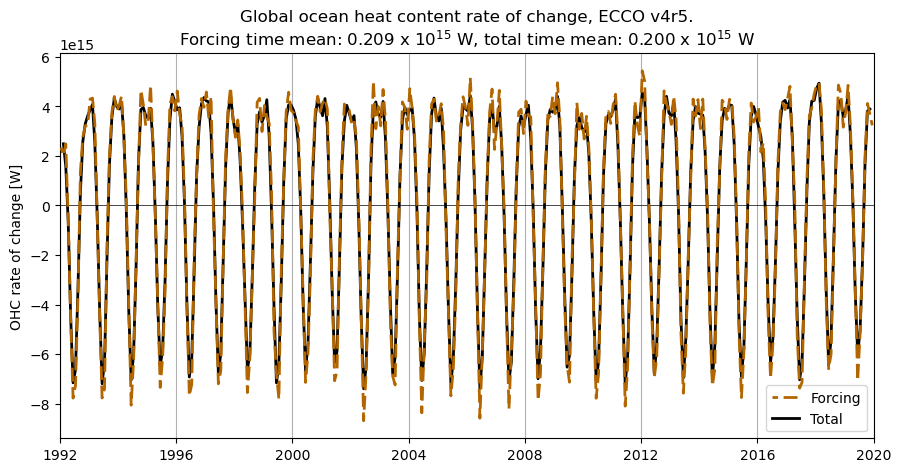

In [6]:
# time means, excluding first and last months when total tendencies are not available
delta_t_v4r5 = xr.DataArray(np.diff(ds_v4r5.time_snp.values).astype('float64')/(1.e9),dims=['time'])
OHC_change_forcing_globmean_tmean_v4r5 = tmean_compute(OHC_change_forcing_globmean_v4r5[1:-1],\
                                                       delta_t_v4r5[1:-1])
OHC_change_total_globmean_tmean_v4r5 = tmean_compute(OHC_change_total_globmean_v4r5[1:-1],\
                                                     delta_t_v4r5[1:-1])

# plot OHC rate of change, v4r5
fig,ax = plt.subplots(1,1,figsize=(10.5,5))
ax.plot(ds_v4r5.time.values,OHC_change_forcing_globmean_v4r5.values,\
        color=(.7,.4,0),linewidth=2,linestyle=(3,(5,2)),zorder=10,label='Forcing')
ax.plot(ds_v4r5.time.values,OHC_change_total_globmean_v4r5.values,\
        color=(0,0,0),linewidth=2,label='Total')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.grid(axis='x')
ax.set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2020-01-01','ns')])
ax.set_ylabel('OHC rate of change [W]')
ax.set_ylabel('OHC rate of change [W]')
ax.set_title('Global ocean heat content rate of change, ECCO v4r5.\n'\
             +'Forcing time mean: '+("%.3f" % ((1.e-15)*OHC_change_forcing_globmean_tmean_v4r5))+' x 10$^{15}$ W,'\
             +' total time mean: '+("%.3f" % ((1.e-15)*OHC_change_total_globmean_tmean_v4r5))+' x 10$^{15}$ W')
plt.legend(loc='lower right')
plt.show()

The matchup between the two time series and their time means is not as precise in v4r5, since we relied on interpolation to obtain the total global OHC change. Nonetheless, they are quite close.

Note that if the above time series are divided by surface area (either the ocean surface area or the Earth's surface area), we would get an effective heat flux in units of W m$^{-2}$. In the ECCO grid, the ocean's surface area is: 

In [7]:
ocean_area_weights = ds_v4r4.hFacC.isel(k=0)*ds_v4r4.rA
ocean_area_sum = ocean_area_weights.sum(['tile','j','i']).compute()
print('Ocean surface area: '+("%.3f" % ((1.e-15)*ocean_area_sum.values))+'e15 m^2')

Ocean surface area: 0.358e15 m^2


In [8]:
area_weights = ds_v4r4.rA
area_sum = area_weights.sum(['tile','j','i']).compute()
print('Earth surface area: '+("%.3f" % ((1.e-15)*area_sum.values))+'e15 m^2')

Earth surface area: 0.510e15 m^2


Dividing by these areas gives us a time mean OHC change per unit area of:

In [9]:
print('v4r4 forcing/ocean area: '+("%.3f" % (OHC_change_forcing_globmean_tmean_v4r4/ocean_area_sum).values)\
      +' W m^-2')
print('v4r5 forcing/ocean area: '+("%.3f" % (OHC_change_forcing_globmean_tmean_v4r5/ocean_area_sum).values)\
      +' W m^-2')
print('v4r4 forcing/Earth area: '+("%.3f" % (OHC_change_forcing_globmean_tmean_v4r4/area_sum).values)\
      +' W m^-2')
print('v4r5 forcing/Earth area: '+("%.3f" % (OHC_change_forcing_globmean_tmean_v4r5/area_sum).values)\
      +' W m^-2')

v4r4 forcing/ocean area: 0.595 W m^-2
v4r5 forcing/ocean area: 0.584 W m^-2
v4r4 forcing/Earth area: 0.418 W m^-2
v4r5 forcing/Earth area: 0.410 W m^-2


Dividing by the Earth's surface area is the most relevant quantity for EEI studies, though dividing by the ocean surface area may be more useful for understanding the ocean-specific energy imbalance. The [von Schuckmann estimates](https://wmo.int/media/news/new-study-shows-earth-energy-imbalance) of the top-of-atmosphere energy imbalance are in the range 0.4-0.8 W m$^{-2}$, so we are at least close to those numbers.

## Components of the heat flux into the ocean

The previous section established that heat fluxes or "forcing" explain the change in the ocean's heat content. Now let's consider the relative contributions of several different types of fluxes. The types that you are probably most familiar with are:

- Radiative fluxes (shortwave + longwave)
- Turbulent fluxes (latent + sensible)

The ECCO variable that contains all of these fluxes into the ocean (from the atmosphere and sea-ice) is `oceQnet`. However, for completeness, we need to consider additional fluxes of heat that are not discussed nearly as much by oceanographers, and which many ocean models neglect:

One is the heat flux associated with the surface freshwater flux--i.e., from the temperature difference between the water removed from the ocean via evaporation vs. the water restored to the ocean via precipitation and runoff. (Note that this is different from the latent heat flux, which is also associated with evaporation but is the heating associated with the phase change of the water, not the temperature change.) There is no ECCO variable that quantifies this flux specifically, but the variable `TFLUX` includes the temperature impact of mass fluxes. Hence the difference `TFLUX` - `oceQnet` should reflect the impact of this flux, and this is demonstrated below.

The other heat flux is the geothermal flux, which of course does not occur across the ocean surface but is necessary to close the ocean's heat budget. The geothermal flux is not archived in a dataset like most ECCO variables, but is included as a binary file in the ECCO ancillary output. This file has also been [archived](https://github.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/tree/master/misc) in the ECCOv4 Python tutorial Github repo, and this notebook accesses the file from there.

ECCO makes quantifying these components of the net heat flux into the ocean fairly straightforward, as you can see in the simple function below.

In [10]:
def G_forcing_components_globmean(ds):
    ocean_area_weights = ds.hFacC.isel(k=0)*ds.rA
    ocean_area_sum = ocean_area_weights.sum(['tile','j','i']).compute()
    oceQnet_globmean = ((ocean_area_weights*ds.oceQnet).sum(['tile','j','i'])\
                            /ocean_area_sum).compute()
    c_p = 3994
    FWflxT = c_p*(ds.oceFWflx*(ds.THETA.isel(k=0)))
    FWflxT_globmean = ((ocean_area_weights*FWflxT).sum(['tile','j','i'])\
                            /ocean_area_sum).compute()
    TFLUX_globmean = ((ocean_area_weights*ds.TFLUX).sum(['tile','j','i'])\
                            /ocean_area_sum).compute()
    GEOFLX = geoflx_retrieve(ds)
    geoflx_globmean = ((ocean_area_weights*((GEOFLX.sum('k'))\
                                            *xr.DataArray(np.ones((ds.sizes['time'],)),dims=['time']))).sum(['tile','j','i'])\
                            /ocean_area_sum).compute()

    return oceQnet_globmean,FWflxT_globmean,TFLUX_globmean,geoflx_globmean

ratio_ocean_global_area = ((ds_v4r4.hFacC.isel(k=0)*ds_v4r4.rA).sum(['tile','j','i'])\
                            /(ds_v4r4.rA.sum(['tile','j','i']))).values

oceQnet_globmean_v4r4,FWflxT_globmean_v4r4,\
    TFLUX_globmean_v4r4,geoflx_globmean_v4r4 = G_forcing_components_globmean(ds_v4r4)
oceQnet_globmean_v4r5,FWflxT_globmean_v4r5,\
    TFLUX_globmean_v4r5,geoflx_globmean_v4r5 = G_forcing_components_globmean(ds_v4r5)

load_binary_array: loading file /home/jovyan/Downloads/geothermalFlux.bin
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
load_binary_array: loading file /home/jovyan/Downloads/geothermalFlux.bin
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


In [11]:
# include first and last months in calculation, since we are no longer reliant on snapshots that may be missing at the endpoints
# to do this, fill in time values at endpoints
t_bnds_v4r4 = np.copy(ds_v4r4.time_snp.values)
t_bnds_v4r4[0] = np.datetime64('1992-01-01T12','ns')
t_bnds_v4r4[-1] = np.datetime64('2018-01-01T00','ns')
delta_t_v4r4 = xr.DataArray(np.diff(t_bnds_v4r4).astype('float64')/1.e9,dims=['time'])

t_bnds_v4r5 = np.copy(ds_v4r5.time_snp.values)
t_bnds_v4r5[0] = np.datetime64('1992-01-01T12','ns')
t_bnds_v4r5[-1] = np.datetime64('2020-01-01T00','ns')
delta_t_v4r5 = xr.DataArray(np.diff(t_bnds_v4r5).astype('float64')/1.e9,dims=['time'])

### Variability and time mean of heat fluxes

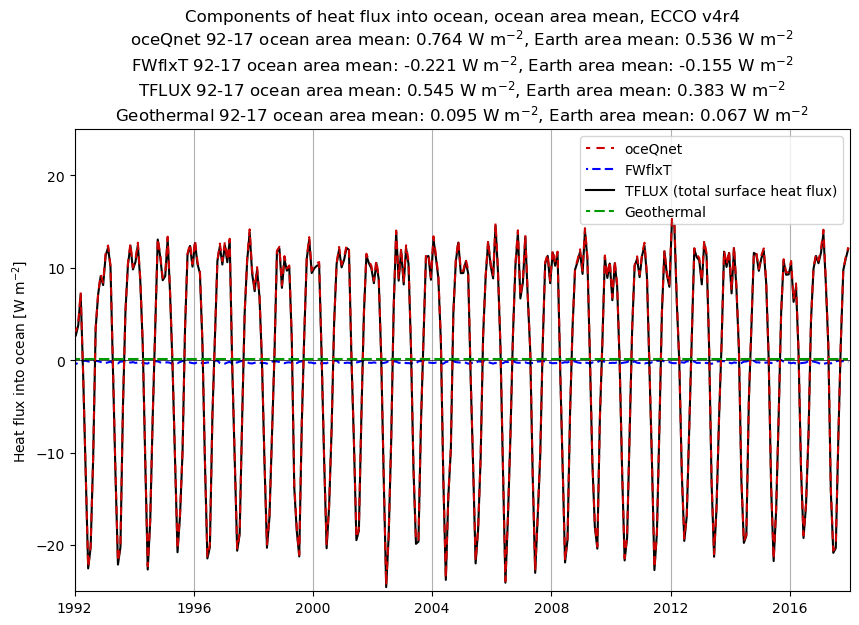

In [12]:
# compute time means
oceQnet_globmean_tmean_v4r4 = tmean_compute(oceQnet_globmean_v4r4,delta_t_v4r4)
FWflxT_globmean_tmean_v4r4 = tmean_compute(FWflxT_globmean_v4r4,delta_t_v4r4)
geoflx_globmean_tmean_v4r4 = tmean_compute(geoflx_globmean_v4r4,delta_t_v4r4)
TFLUX_globmean_tmean_v4r4 = tmean_compute(TFLUX_globmean_v4r4,delta_t_v4r4)

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(ds_v4r4.time.values,oceQnet_globmean_v4r4.values,color=(.8,0,0),linestyle=(2,(4,3)),zorder=20,label='oceQnet')
ax.plot(ds_v4r4.time.values,FWflxT_globmean_v4r4.values,color=(0,0,1),linestyle=(3,(4,2)),label='FWflxT')
ax.plot(ds_v4r4.time.values,TFLUX_globmean_v4r4.values,color=(0,0,0),label='TFLUX (total surface heat flux)')
ax.plot(ds_v4r4.time.values,geoflx_globmean_v4r4.values,color=(0,.6,0),linestyle=(3,(5,2)),zorder=100,label='Geothermal')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.grid(axis='x')
ax.set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2018-01-01','ns')])
ax.set_ylim([-25,25])
ax.set_ylabel('Heat flux into ocean [W m$^{-2}$]')
ax.set_title('Components of heat flux into ocean, ocean area mean, ECCO v4r4\n'\
             +'oceQnet 92-17 ocean area mean: '+("%.3f" % oceQnet_globmean_tmean_v4r4.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*oceQnet_globmean_tmean_v4r4.values))+' W m$^{-2}$\n'\
             +'FWflxT 92-17 ocean area mean: '+("%.3f" % FWflxT_globmean_tmean_v4r4.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*FWflxT_globmean_tmean_v4r4.values))+' W m$^{-2}$\n'\
             +'TFLUX 92-17 ocean area mean: '+("%.3f" % TFLUX_globmean_tmean_v4r4.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*TFLUX_globmean_tmean_v4r4.values))+' W m$^{-2}$\n'\
             +'Geothermal 92-17 ocean area mean: '+("%.3f" % geoflx_globmean_tmean_v4r4.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*geoflx_globmean_tmean_v4r4.values))+' W m$^{-2}$')
plt.legend(loc='upper right')
plt.show()

Two points to consider about the plot above:

- `oceQnet` (radiative + turbulent heat flux) explains nearly all of the temporal variability in the surface heat flux. However, if we assumed that `oceQnet` contained *all* of the surface heat flux, the estimate of the time mean surface heat flux would be overestimated by ~40%. The relatively steady cooling from evaporated water being warmer than water that is returned to the ocean via precipitation or runoff is a significant part of the global heat budget. This freshwater-associated heat flux (denoted here as `FWflxT`) is distinct from the latent heat flux already contained in `oceQnet`, but like the latent heat flux it moves heat from the ocean to the atmosphere.

- The time mean numbers above show that `oceQnet` + `FWflxT` $\approx$ `TFLUX`, even though `FWflxT` was computed only with monthly means of the freshwater flux and temperature (rather than at each timestep of the model). So this is an encouraging check on our calculations.

Let's redo the above plot, removing `TFLUX` and instead focusing on how the three components `oceQnet`, `FWflxT`, and `Geothermal` contribute to the total OHC change.

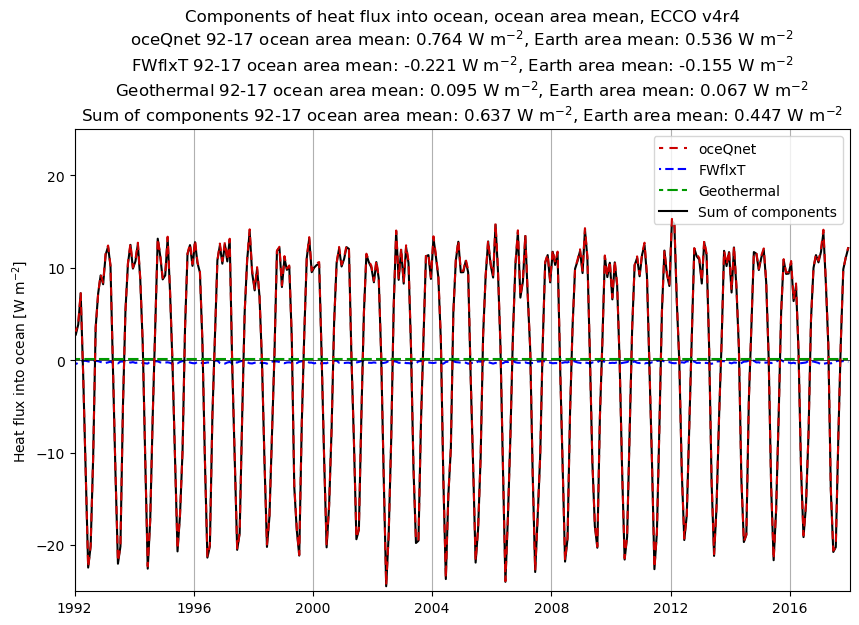

In [13]:
# sum of 3 components of heat flux into the ocean
sum_comp_globmean_v4r4 = oceQnet_globmean_v4r4 + FWflxT_globmean_v4r4 + geoflx_globmean_v4r4
sum_comp_globmean_tmean_v4r4 = tmean_compute(sum_comp_globmean_v4r4,delta_t_v4r4)


fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(ds_v4r4.time.values,oceQnet_globmean_v4r4.values,color=(.8,0,0),linestyle=(2,(4,3)),zorder=20,label='oceQnet')
ax.plot(ds_v4r4.time.values,FWflxT_globmean_v4r4.values,color=(0,0,1),linestyle=(3,(4,2)),label='FWflxT')
ax.plot(ds_v4r4.time.values,geoflx_globmean_v4r4.values,color=(0,.6,0),linestyle=(3,(5,2)),zorder=100,label='Geothermal')
ax.plot(ds_v4r4.time.values,sum_comp_globmean_v4r4.values,color=(0,0,0),label='Sum of components')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.grid(axis='x')
ax.set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2018-01-01','ns')])
ax.set_ylim([-25,25])
ax.set_ylabel('Heat flux into ocean [W m$^{-2}$]')
ax.set_title('Components of heat flux into ocean, ocean area mean, ECCO v4r4\n'\
             +'oceQnet 92-17 ocean area mean: '+("%.3f" % oceQnet_globmean_tmean_v4r4.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*oceQnet_globmean_tmean_v4r4.values))+' W m$^{-2}$\n'\
             +'FWflxT 92-17 ocean area mean: '+("%.3f" % FWflxT_globmean_tmean_v4r4.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*FWflxT_globmean_tmean_v4r4.values))+' W m$^{-2}$\n'\
             +'Geothermal 92-17 ocean area mean: '+("%.3f" % geoflx_globmean_tmean_v4r4.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*geoflx_globmean_tmean_v4r4.values))+' W m$^{-2}$\n'\
             +'Sum of components 92-17 ocean area mean: '+("%.3f" % sum_comp_globmean_tmean_v4r4.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*sum_comp_globmean_tmean_v4r4.values))+' W m$^{-2}$')
plt.legend(loc='upper right')
plt.show()

And what if we omit the first and last months from the time mean, as we did in the previous section?

In [14]:
sum_comp_globmean_tmean_nofirstlast_v4r4 = \
            tmean_compute(sum_comp_globmean_v4r4[1:-1],delta_t_v4r4[1:-1])
sum_comp_globmean_tmean_nofirstlast_Eartharea_v4r4 = \
            ratio_ocean_global_area*sum_comp_globmean_tmean_nofirstlast_v4r4

print('v4r4 sum comp/ocean area: '+("%.3f" % sum_comp_globmean_tmean_nofirstlast_v4r4.values)\
      +' W m^-2')
print('v4r4 sum comp/Earth area: '+("%.3f" % sum_comp_globmean_tmean_nofirstlast_Eartharea_v4r4.values)\
      +' W m^-2')

v4r4 sum comp/ocean area: 0.593 W m^-2
v4r4 sum comp/Earth area: 0.416 W m^-2


These values are within 1% of the values for the total forcing contributions, computed from `TFLUX` + `Geothermal` at the end of the "Ocean heat content change" section.

Reproducing the plot above with v4r5 (focusing on the 1992-2017 period that overlaps with both versions):

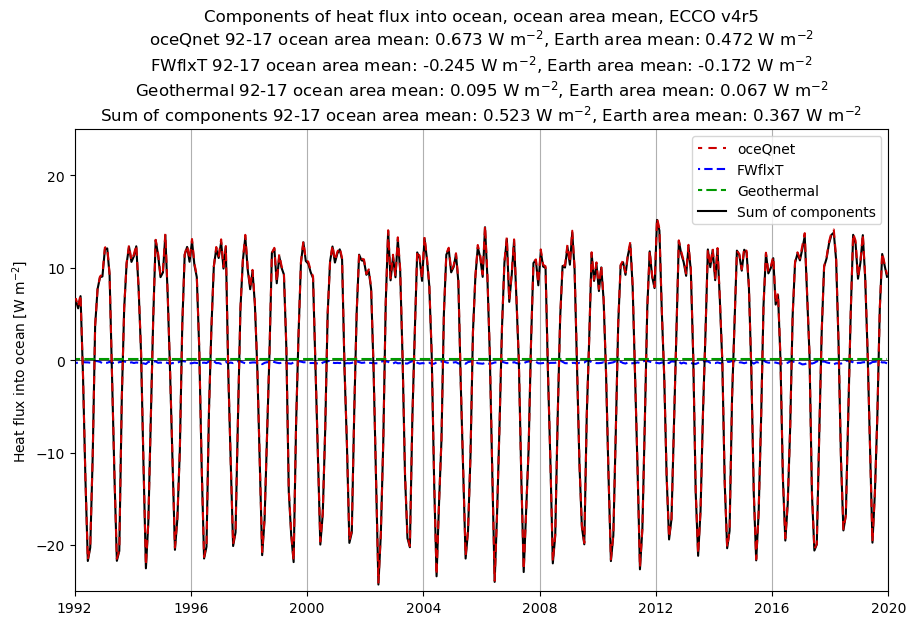

In [15]:
# 1992-2017 time means in v4r5
oceQnet_globmean_tmean_v4r5 = tmean_compute(oceQnet_globmean_v4r5[:-24],delta_t_v4r5[:-24])
FWflxT_globmean_tmean_v4r5 = tmean_compute(FWflxT_globmean_v4r5[:-24],delta_t_v4r5[:-24])
geoflx_globmean_tmean_v4r5 = tmean_compute(geoflx_globmean_v4r5[:-24],delta_t_v4r5[:-24])
sum_comp_globmean_v4r5 = oceQnet_globmean_v4r5 + FWflxT_globmean_v4r5 + geoflx_globmean_v4r5
sum_comp_globmean_tmean_v4r5 = tmean_compute(sum_comp_globmean_v4r5[:-24],delta_t_v4r5[:-24])


fig,ax = plt.subplots(1,1,figsize=(10.5,6))
ax.plot(ds_v4r5.time.values,oceQnet_globmean_v4r5.values,color=(.8,0,0),linestyle=(2,(4,3)),zorder=20,label='oceQnet')
ax.plot(ds_v4r5.time.values,FWflxT_globmean_v4r5.values,color=(0,0,1),linestyle=(3,(4,2)),label='FWflxT')
ax.plot(ds_v4r5.time.values,geoflx_globmean_v4r5.values,color=(0,.6,0),linestyle=(3,(5,2)),zorder=100,label='Geothermal')
ax.plot(ds_v4r5.time.values,sum_comp_globmean_v4r5.values,color=(0,0,0),label='Sum of components')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.grid(axis='x')
ax.set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2020-01-01','ns')])
ax.set_ylim([-25,25])
ax.set_ylabel('Heat flux into ocean [W m$^{-2}$]')
ax.set_title('Components of heat flux into ocean, ocean area mean, ECCO v4r5\n'\
             +'oceQnet 92-17 ocean area mean: '+("%.3f" % oceQnet_globmean_tmean_v4r5.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*oceQnet_globmean_tmean_v4r5.values))+' W m$^{-2}$\n'\
             +'FWflxT 92-17 ocean area mean: '+("%.3f" % FWflxT_globmean_tmean_v4r5.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*FWflxT_globmean_tmean_v4r5.values))+' W m$^{-2}$\n'\
             +'Geothermal 92-17 ocean area mean: '+("%.3f" % geoflx_globmean_tmean_v4r5.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*geoflx_globmean_tmean_v4r5.values))+' W m$^{-2}$\n'\
             +'Sum of components 92-17 ocean area mean: '+("%.3f" % sum_comp_globmean_tmean_v4r5.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*sum_comp_globmean_tmean_v4r5.values))+' W m$^{-2}$')
plt.legend(loc='upper right')
plt.show()

The difference between the v4r4 and v4r5 time means is up to ~20% for the same period (1992-2017), underscoring the challenge of getting accurate estimates of the ocean's energy imbalance.

### Trends in heat fluxes

Presumably at some time in the not-too-distant past (preindustrial era, or even more recently when global greenhouse emissions were lower), the ocean's energy imbalance was lower or even had the sign reversed. Hence we might be interested not only in what the time mean of the imbalance is, but the trend in recent decades. Below we can quantify the trends in each component of the heat flux, keeping in mind that ECCO only goes back to 1992 so it is a relatively short time window to look for an emissions-related trend.

In [16]:
def trend_compute(input_array,axis=-1,delta_dim=1,output_trendline=False):
    """
    Computes linear regression-based trend in NumPy array input_array, along specified axis with interval delta_dim.
    Outputs trend values in reg_trend.
    If output_trendline = True, also outputs trend lines in reg_trendline."""
    
    input_reshaped = np.moveaxis(input_array,axis,0)
    input_shape = input_reshaped.shape
    dim_vec = np.arange(0.,input_shape[0])
    mask = np.asarray(np.logical_and(np.logical_and(~np.isnan(input_reshaped),~np.isinf(input_reshaped)),\
                                      np.abs(input_reshaped) > 1e-10*np.nanmax(np.abs(input_reshaped))))
    dim_vec_tiled = np.moveaxis(np.tile(dim_vec,np.concatenate((input_shape[1:],[1]))),-1,0)
    dim_vec_nomean = dim_vec_tiled - (np.sum(mask*dim_vec_tiled,axis=0)/np.sum(mask,axis=0))
    input_mean = np.nansum(mask*input_reshaped,axis=0,keepdims=True)/np.nansum(mask,axis=0,keepdims=True)
    input_nomean = input_reshaped - input_mean
    reg_num = np.nansum(mask*(dim_vec_nomean*input_nomean),axis=0,keepdims=True)
    reg_denom = np.nansum(mask*(dim_vec_nomean**2),axis=0,keepdims=True)
    reg_trend = (np.moveaxis(reg_num/reg_denom,0,axis))/delta_dim
    if output_trendline == True:
        reg_trendline = np.moveaxis(input_mean,0,axis) + (delta_dim*reg_trend*np.moveaxis(dim_vec_nomean,0,axis))
        return reg_trend,reg_trendline
    else:    
        return reg_trend

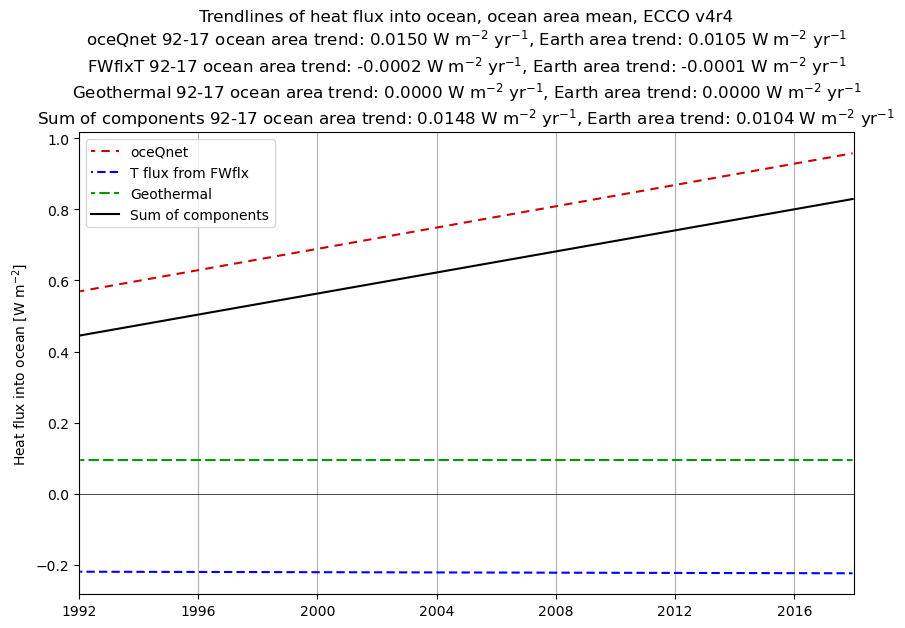

In [17]:
# trends, computed with weights based on month length
trend_normalization = (delta_t_v4r4.sum('time')/len(delta_t_v4r4)).values
oceQnet_globmean_v4r4_trendperyr,oceQnet_globmean_v4r4_trendline = \
            trend_compute((delta_t_v4r4*oceQnet_globmean_v4r4).values,delta_dim=1/12,output_trendline=True)
oceQnet_globmean_v4r4_trendperyr = oceQnet_globmean_v4r4_trendperyr/trend_normalization
oceQnet_globmean_v4r4_trendline = oceQnet_globmean_v4r4_trendline/trend_normalization
FWflxT_globmean_v4r4_trendperyr,FWflxT_globmean_v4r4_trendline = \
            trend_compute((delta_t_v4r4*FWflxT_globmean_v4r4).values,delta_dim=1/12,output_trendline=True)
FWflxT_globmean_v4r4_trendperyr = FWflxT_globmean_v4r4_trendperyr/trend_normalization
FWflxT_globmean_v4r4_trendline = FWflxT_globmean_v4r4_trendline/trend_normalization
geoflx_globmean_v4r4_trendperyr,geoflx_globmean_v4r4_trendline = \
            trend_compute((delta_t_v4r4*geoflx_globmean_v4r4).values,delta_dim=1/12,output_trendline=True)
geoflx_globmean_v4r4_trendperyr = geoflx_globmean_v4r4_trendperyr/trend_normalization
geoflx_globmean_v4r4_trendline = geoflx_globmean_v4r4_trendline/trend_normalization
sum_comp_globmean_v4r4_trendperyr,sum_comp_globmean_v4r4_trendline = \
            trend_compute((delta_t_v4r4*sum_comp_globmean_v4r4).values,delta_dim=1/12,output_trendline=True)
sum_comp_globmean_v4r4_trendperyr = sum_comp_globmean_v4r4_trendperyr/trend_normalization
sum_comp_globmean_v4r4_trendline = sum_comp_globmean_v4r4_trendline/trend_normalization

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(ds_v4r4.time.values,oceQnet_globmean_v4r4_trendline,\
                color=(.8,0,0),linestyle=(2,(4,3)),zorder=20,label='oceQnet')
ax.plot(ds_v4r4.time.values,FWflxT_globmean_v4r4_trendline,\
                color=(0,0,1),linestyle=(3,(4,2)),label='T flux from FWflx')
ax.plot(ds_v4r4.time.values,geoflx_globmean_v4r4_trendline,\
                color=(0,.6,0),linestyle=(3,(5,2)),zorder=100,label='Geothermal')
ax.plot(ds_v4r4.time.values,sum_comp_globmean_v4r4_trendline,\
                color=(0,0,0),label='Sum of components')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.grid(axis='x')
ax.set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2018-01-01','ns')])
ax.set_ylabel('Heat flux into ocean [W m$^{-2}$]')
ax.set_title('Trendlines of heat flux into ocean, ocean area mean, ECCO v4r4\n'\
             +'oceQnet 92-17 ocean area trend: '+("%.4f" % oceQnet_globmean_v4r4_trendperyr[0])+' W m$^{-2}$ yr$^{-1}$,'\
             +' Earth area trend: '+("%.4f" % (ratio_ocean_global_area*oceQnet_globmean_v4r4_trendperyr[0]))\
                         +' W m$^{-2}$ yr$^{-1}$\n'\
             +'FWflxT 92-17 ocean area trend: '+("%.4f" % FWflxT_globmean_v4r4_trendperyr[0])+' W m$^{-2}$ yr$^{-1}$,'\
             +' Earth area trend: '+("%.4f" % (ratio_ocean_global_area*FWflxT_globmean_v4r4_trendperyr[0]))\
                         +' W m$^{-2}$ yr$^{-1}$\n'\
             +'Geothermal 92-17 ocean area trend: '+("%.4f" % geoflx_globmean_v4r4_trendperyr[0])+' W m$^{-2}$ yr$^{-1}$,'\
             +' Earth area trend: '+("%.4f" % (ratio_ocean_global_area*geoflx_globmean_v4r4_trendperyr[0]))\
                         +' W m$^{-2}$ yr$^{-1}$\n'\
             +'Sum of components 92-17 ocean area trend: '+("%.4f" % sum_comp_globmean_v4r4_trendperyr[0])+' W m$^{-2}$ yr$^{-1}$,'\
             +' Earth area trend: '+("%.4f" % (ratio_ocean_global_area*sum_comp_globmean_v4r4_trendperyr[0]))\
                         +' W m$^{-2}$ yr$^{-1}$')
plt.legend()
plt.show()

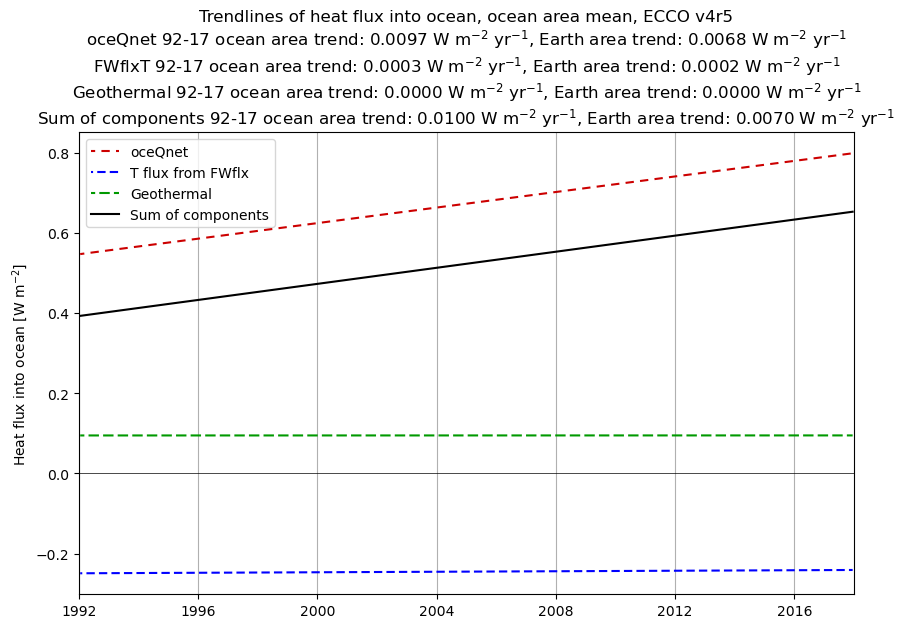

In [18]:
# now for v4r5, 1992-2017

# trends, computed with weights based on month length
trend_normalization = (delta_t_v4r5[:-24].sum('time')/len(delta_t_v4r5[:-24])).values
oceQnet_globmean_v4r5_trendperyr,oceQnet_globmean_v4r5_trendline = \
            trend_compute((delta_t_v4r5*oceQnet_globmean_v4r5).values[:-24],delta_dim=1/12,output_trendline=True)
oceQnet_globmean_v4r5_trendperyr = oceQnet_globmean_v4r5_trendperyr/trend_normalization
oceQnet_globmean_v4r5_trendline = oceQnet_globmean_v4r5_trendline/trend_normalization
FWflxT_globmean_v4r5_trendperyr,FWflxT_globmean_v4r5_trendline = \
            trend_compute((delta_t_v4r5*FWflxT_globmean_v4r5).values[:-24],delta_dim=1/12,output_trendline=True)
FWflxT_globmean_v4r5_trendperyr = FWflxT_globmean_v4r5_trendperyr/trend_normalization
FWflxT_globmean_v4r5_trendline = FWflxT_globmean_v4r5_trendline/trend_normalization
geoflx_globmean_v4r5_trendperyr,geoflx_globmean_v4r5_trendline = \
            trend_compute((delta_t_v4r5*geoflx_globmean_v4r5).values[:-24],delta_dim=1/12,output_trendline=True)
geoflx_globmean_v4r5_trendperyr = geoflx_globmean_v4r5_trendperyr/trend_normalization
geoflx_globmean_v4r5_trendline = geoflx_globmean_v4r5_trendline/trend_normalization
sum_comp_globmean_v4r5_trendperyr,sum_comp_globmean_v4r5_trendline = \
            trend_compute((delta_t_v4r5*sum_comp_globmean_v4r5).values[:-24],delta_dim=1/12,output_trendline=True)
sum_comp_globmean_v4r5_trendperyr = sum_comp_globmean_v4r5_trendperyr/trend_normalization
sum_comp_globmean_v4r5_trendline = sum_comp_globmean_v4r5_trendline/trend_normalization

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(ds_v4r5.time[:-24].values,oceQnet_globmean_v4r5_trendline,\
                color=(.8,0,0),linestyle=(2,(4,3)),zorder=20,label='oceQnet')
ax.plot(ds_v4r5.time[:-24].values,FWflxT_globmean_v4r5_trendline,\
                color=(0,0,1),linestyle=(3,(4,2)),label='T flux from FWflx')
ax.plot(ds_v4r5.time[:-24].values,geoflx_globmean_v4r5_trendline,\
                color=(0,.6,0),linestyle=(3,(5,2)),zorder=100,label='Geothermal')
ax.plot(ds_v4r5.time[:-24].values,sum_comp_globmean_v4r5_trendline,\
                color=(0,0,0),label='Sum of components')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.grid(axis='x')
ax.set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2018-01-01','ns')])
ax.set_ylabel('Heat flux into ocean [W m$^{-2}$]')
ax.set_title('Trendlines of heat flux into ocean, ocean area mean, ECCO v4r5\n'\
             +'oceQnet 92-17 ocean area trend: '+("%.4f" % oceQnet_globmean_v4r5_trendperyr[0])+' W m$^{-2}$ yr$^{-1}$,'\
             +' Earth area trend: '+("%.4f" % (ratio_ocean_global_area*oceQnet_globmean_v4r5_trendperyr[0]))\
                         +' W m$^{-2}$ yr$^{-1}$\n'\
             +'FWflxT 92-17 ocean area trend: '+("%.4f" % FWflxT_globmean_v4r5_trendperyr[0])+' W m$^{-2}$ yr$^{-1}$,'\
             +' Earth area trend: '+("%.4f" % (ratio_ocean_global_area*FWflxT_globmean_v4r5_trendperyr[0]))\
                         +' W m$^{-2}$ yr$^{-1}$\n'\
             +'Geothermal 92-17 ocean area trend: '+("%.4f" % geoflx_globmean_v4r5_trendperyr[0])+' W m$^{-2}$ yr$^{-1}$,'\
             +' Earth area trend: '+("%.4f" % (ratio_ocean_global_area*geoflx_globmean_v4r5_trendperyr[0]))\
                         +' W m$^{-2}$ yr$^{-1}$\n'\
             +'Sum of components 92-17 ocean area trend: '+("%.4f" % sum_comp_globmean_v4r5_trendperyr[0])+' W m$^{-2}$ yr$^{-1}$,'\
             +' Earth area trend: '+("%.4f" % (ratio_ocean_global_area*sum_comp_globmean_v4r5_trendperyr[0]))\
                         +' W m$^{-2}$ yr$^{-1}$')
plt.legend()
plt.show()

In looking at the trendlines from v4r4 and v4r5, we see that:

- `oceQnet` has a substantial trend relative to the time mean value; for example in v4r4, it increases by nearly 0.4 W m$^{-2}$ in the 26-year ECCOv4r4 period. The trend in `FWflxT` is extremely small however, and the trend in `Geothermal` is zero by definition (the geothermal heat flux inputs in ECCO are constant in time).

- As with the time mean, there are large differences in the trends between v4r4 and v4r5...the trend in `oceQnet` is ~50% larger in v4r4 compared to v4r5. Another demonstration of why numerous models and observational datasets are needed to help constrain estimates of the ocean's (and the Earth's) energy imbalance.